## DataLoader
- [param] read dataset list, list of jpg
    -  assume has corresponding xml file beside
- [param] .name file for label hashing
- read bbbox data
- build dict [image path: annotation]


### Import

In [1]:
from torch.utils.data.dataset import Dataset

In [11]:
import random
import cv2
import sys
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

from voc_io import *

%load_ext autoreload
%autoreload 2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Pytorch Dataset


In [7]:
class Detection_dataset(Dataset):
    def __init__(self, image_paths, cfg=None):
        super(Detection_dataset, self).__init__()
        
        self.cfg = cfg
        
        names = ["palm1_npt", "palm1_byt", "palm2_mtl"]
        self.names = {name:i for i,name in enumerate(names)}
        self.id_names = {i: name for i,name in enumerate(names)}
        
        truth = {}
        f = open(image_paths, 'r', encoding='utf-8')
        for line in f.readlines():
            path = line.rstrip()
            truth[path] = self.read_annot(path)         
        self.truth = truth
        
    def read_annot(self, jpg):
        parts = jpg.split('.')
        parts[-1] = 'xml'
        xml = '.'.join(parts)
        
        annots = PascalVocReader(xml).getAnnot()
        for annot in annots:
            uid = self.names.get(annot[-1], None)
            if uid == None:
                uid = self.extend_name(annot[-1])
            annot[-1] = uid
        return annots
        
    def extend_name(self, name):
        newId = len(self.names.keys())
        self.names[name] = newId
        self.id_names[newId] = name
        print("Added Missing Name: %d, %s"%(newId, name))
        return newId
        
    def __getitem__(self, index):
        img_path = list(self.truth.keys())[index]
        bboxes = np.array(self.truth.get(img_path), dtype=np.float)
        
#         img_path = os.path.join(self.cfg.dataset_dir, img_path)

        ## read image
        img = cv2.imread(img_path)
    
        ## augmentation
        out_img = img
        out_bboxes = bboxes
        
        ## return: img_tensor, annotation
        return out_img, out_bboxes
    
        
    def __len__(self):
        return len(self.truth.keys())
    
    def visualize(self, index):
        img_src, bboxes = self[index]
        
        img = img_src.copy()
        for b in bboxes:
            b = list(map(int,b))
            cv2.rectangle(img, (b[0],b[1]), (b[2],b[3]), (0,0,255), 4)
            text = self.id_names[b[4]]
            cv2.putText(img, text, (b[0],b[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,0,0), 5)
        
        plt.figure()
        plt.imshow(img)


In [8]:
data_list = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/train.txt"
dataset = Detection_dataset(data_list)

In [9]:
dataset.names

{'palm1_npt': 0, 'palm1_byt': 1, 'palm2_mtl': 2}

# Dataset : 207
Sample: 
/Users/ckh/OneDrive - Default Directory/Hui_Wan/Sample_Anno_Data_BYT/10_gsge_op16b_0001.JPG
Items: 
[[176, 210, 379, 413, 1], [527, 287, 707, 467, 1], [636, 536, 861, 761, 1], [794, 821, 988, 1000, 1], [461, 821, 655, 1000, 1], [345, 516, 548, 719, 1], [10, 510, 199, 699, 1], [125, 796, 337, 1000, 1], [846, 311, 1000, 480, 1]]


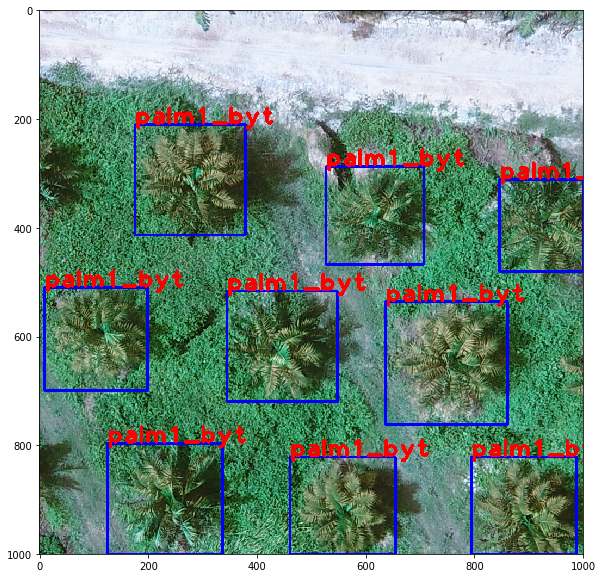

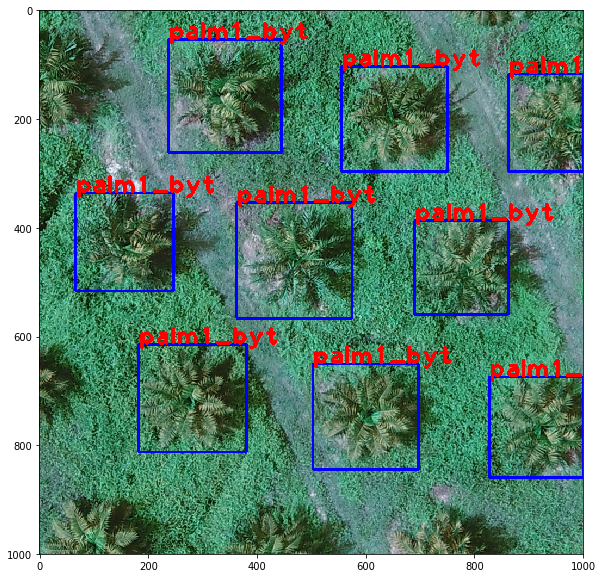

In [12]:
print("# Dataset :", len(dataset.truth))

print("Sample: ")
key = list(dataset.truth.keys())[0]
print(key)
print("Items: ")
print(dataset.truth[key])

dataset.visualize(0)
dataset.visualize(1)

## New heading